In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Annotated, Optional
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage

def last_message_reducer(existing, update):
    return update 

In [2]:
class AgentState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], last_message_reducer]
    context: Optional[str]
    tool_responses: dict
    needs_refinement: bool
    required_components: List[str]
    needs_text: bool
    needs_images: bool
    needs_pdf: bool
    iteration_count: int

In [3]:
def retrieve_context():
    return "context"
def supervisor():
    return "context"
def execute_tools():
    return "context"
def quality_check():
    return "context"

def format_response():
    return "context"

def route_tools(self, state: AgentState):
        if any([state.get("needs_text"), state.get("needs_images"), state.get("needs_pdf")]):
            return "continue"
        return "respond"

def check_quality_and_complexity(self, state: AgentState) -> str:
        state["iteration_count"] = state.get("iteration_count", 0) + 1
        max_iterations = 2 
        query_length = len(state["messages"][-1].content.strip())
        is_simple = query_length < 500
        if is_simple or state["iteration_count"] >= max_iterations:
            return "approve"
        else:
            return "refine"

In [13]:
def classify_msg(input):
    "classify if message is simple greeting or user question"

    prompt = f"classify this input: {input} if greeting return greeting, else return rag"

    if input == "prompt":
        return "greeting"
    else:
        return "rag"

In [ ]:



workflow = StateGraph(AgentState)

workflow.add_node("classify", classify_msg)
workflow.add_node("retrieve_context", retrieve_context)
workflow.add_node("supervisor", supervisor)
workflow.add_node("execute_tools", execute_tools)
workflow.add_node("quality_check", quality_check)
workflow.add_node("format_response", format_response)

workflow.set_entry_point("supervisor")
workflow.add_edge("supervisor", "classify")

workflow.add_conditional_edges("classify", classify_msg)
workflow.add_edge("rag", "retrieve_context")
workflow.add_edge("greeting", "format_response")

workflow.add_edge("supervisor", "retrieve_context")
workflow.add_edge("retrieve_context", "execute_tools")
        
workflow.add_conditional_edges(
            "supervisor",
            route_tools,
            {"continue": "execute_tools", "respond": "format_response"}
        )
        
workflow.add_edge("execute_tools", "quality_check")
        
        #self.workflow.add_edge("quality_check", "")
        
workflow.add_conditional_edges(
            "quality_check",
            check_quality_and_complexity,
            {"refine": "supervisor", "approve": "format_response"}
        )
        

workflow.add_edge("format_response", END)

app = workflow.compile()

ValueError: Found edge starting at unknown node 'greeting'

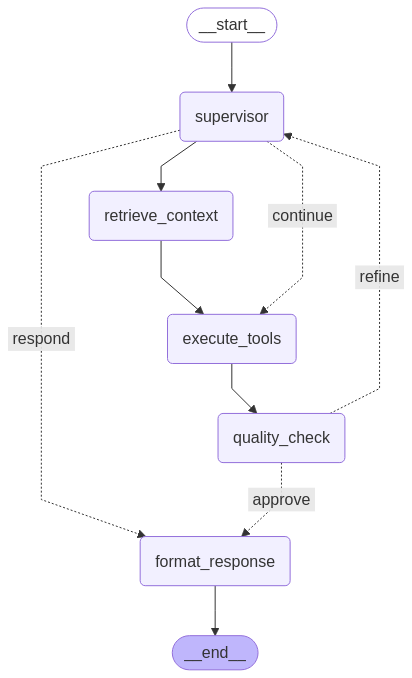

In [10]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))
